## Máster en Data Science - Series Temporales

# XGBoost & LightGBM Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

Los modelos XGBoost y LightGBM son algoritmos avanzados de aprendizaje automático basados en gradient boosting que han demostrado ser altamente efectivos para tareas de predicción. Ambos modelos se caracterizan por su capacidad para manejar grandes volúmenes de datos, capturar relaciones no lineales y ajustar patrones complejos, lo que los hace ideales para escenarios como la predicción de pasajeros de autobús y metro de Madrid. En este contexto, estos modelos pueden aprovechar características adicionales, como retardos (lags), componentes estacionales y variables externas, para capturar mejor las dinámicas de la demanda. Además, su robustez frente a datos ruidosos y su capacidad para optimizar errores de manera eficiente los posicionan como alternativas sólidas a los métodos tradicionales.

A pesar de sus similitudes, XGBoost y LightGBM tienen diferencias clave en su diseño. XGBoost utiliza una técnica de boosting basada en árboles más conservadora, enfocándose en garantizar un ajuste robusto y preciso, aunque con un costo computacional más alto. Por otro lado, LightGBM está diseñado para ser más rápido y eficiente en memoria, gracias a su enfoque de histogramas y su capacidad para manejar grandes conjuntos de datos con altas dimensiones. Estas características permiten que ambos modelos se adapten bien a los datos complejos y estacionales de las series temporales de transporte público en Madrid, proporcionando predicciones precisas y eficientes cuando se configuran y ajustan adecuadamente.

In [2]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import warnings

warnings.filterwarnings('ignore')

### Importación de datos

In [3]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [4]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [5]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("ME").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("ME").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("ME").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***
## Modelo XGBoost
El modelo XGBoostRegressor es un algoritmo de aprendizaje supervisado basado en la técnica de gradient boosting, diseñado específicamente para tareas de regresión. Este modelo combina múltiples árboles de decisión secuenciales, donde cada árbol se construye para corregir los errores de los árboles anteriores, optimizando una función objetivo específica mediante un proceso de descenso por gradiente. XGBoostRegressor se destaca por su eficiencia computacional y su capacidad para manejar datos complejos, gracias a características como la regularización incorporada, el manejo eficiente de valores faltantes y su compatibilidad con paralelización. Es especialmente útil para capturar relaciones no lineales en los datos y funciona bien con grandes volúmenes de información, lo que lo hace adecuado para una amplia gama de problemas de predicción, incluidos series temporales y datos estructurados.

### Series mensuales XGBoost

Autobús Mensual - MSE: 59.27, RMSE: 7.70, MAPE: 18.44%


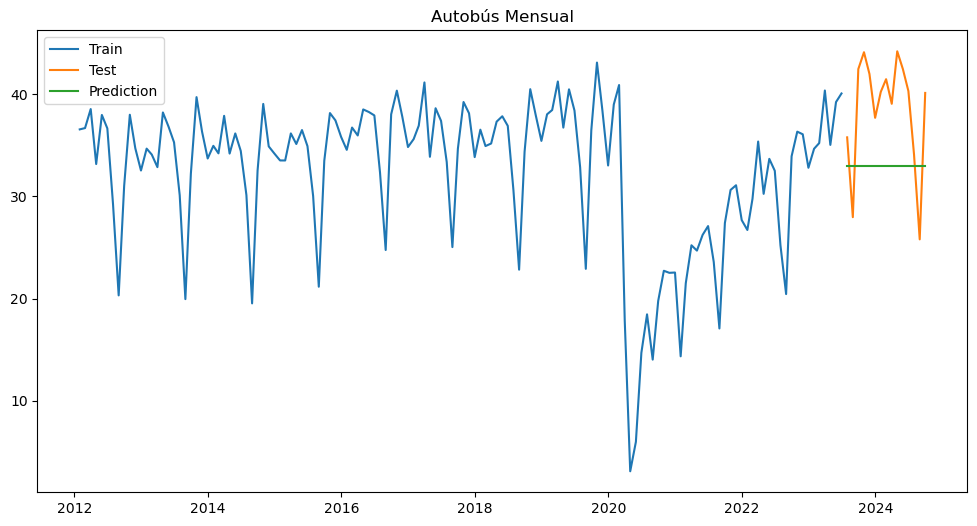

Metro Mensual - MSE: 116.86, RMSE: 10.81, MAPE: 18.22%


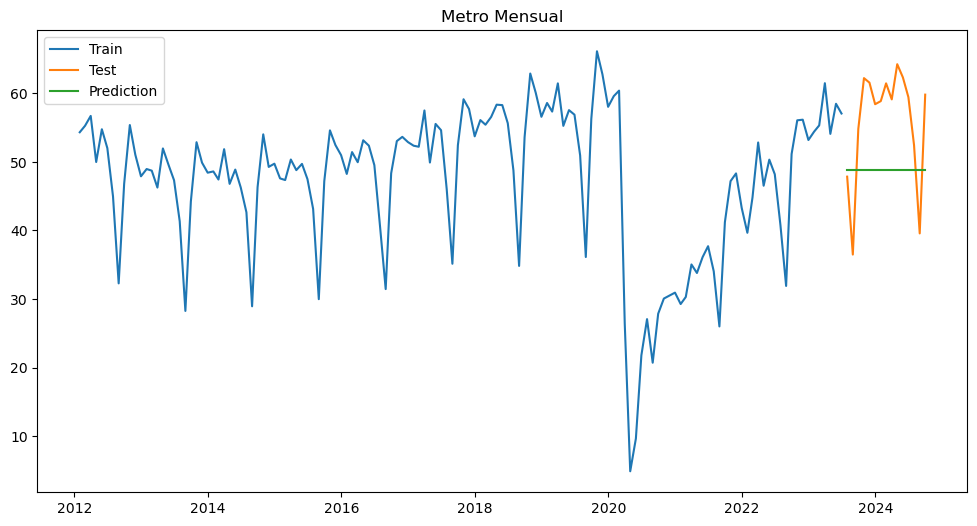

Combinado Mensual - MSE: 339.57, RMSE: 18.43, MAPE: 18.25%


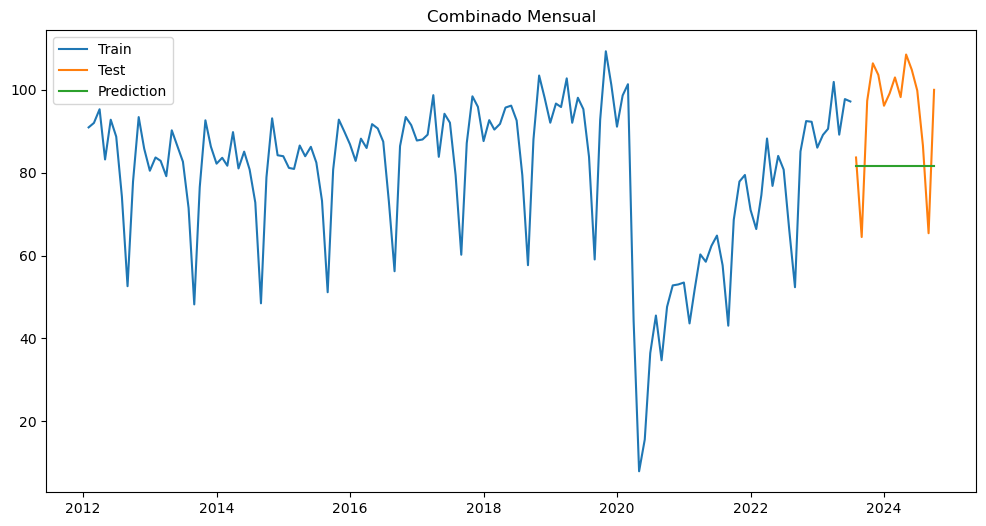

In [6]:
# Preparar los datos
def prepare_data(df):
    X = np.arange(len(df)).reshape(-1, 1)
    y = df.values
    return X, y

# Generar predicciones y graficar
def train_and_plot(df, title, test_size=15):
    X, y = prepare_data(df)
    
    # Ensure test_size does not exceed the length of the dataset
    test_size = min(test_size, len(df) - 1)
    
    # Dividir en train y test
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    
    # Definir el modelo base
    model = XGBRegressor()
    
    # Definir el espacio de búsqueda
    search_spaces = {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(1, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0)
    }
    
    # Configurar la búsqueda bayesiana con validación cruzada
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=32,
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    # Entrenar el modelo
    opt.fit(X_train, y_train)
    
    # Mejor modelo
    best_model = opt.best_estimator_
    
    # Predicciones
    y_pred = best_model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f'{title} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}')
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:-test_size], y_train, label='Train')
    plt.plot(df.index[-test_size:], y_test, label='Test')
    plt.plot(df.index[-test_size:], y_pred, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

# Aplicar a los tres dataframes mensuales
train_and_plot(df_autobus_month, 'Autobús Mensual')
train_and_plot(df_metro_month, 'Metro Mensual')
train_and_plot(df_combined_month, 'Combinado Mensual')


### Series trimestrales XGBoost

Autobús Mensual - MSE: 389.82, RMSE: 19.74, MAPE: 13.99%


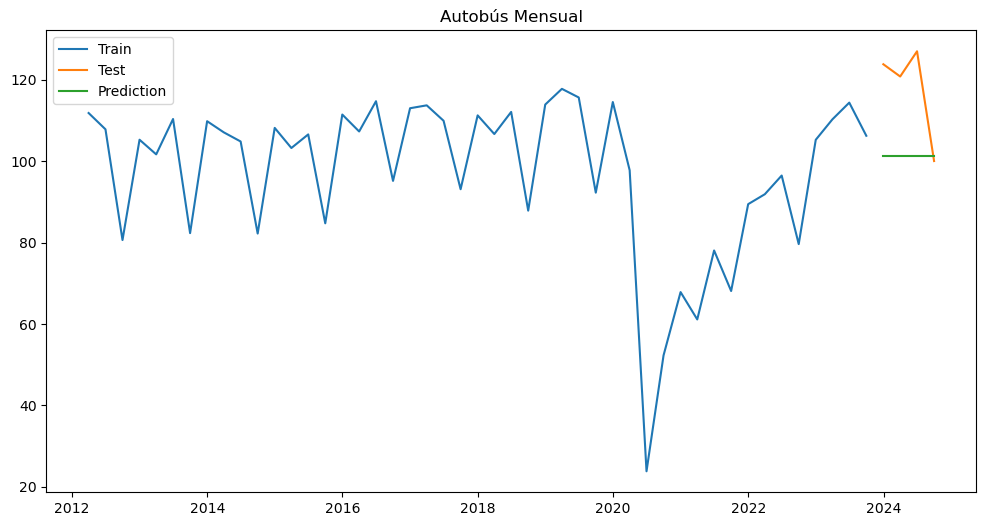

Metro Mensual - MSE: 1300.54, RMSE: 36.06, MAPE: 18.59%


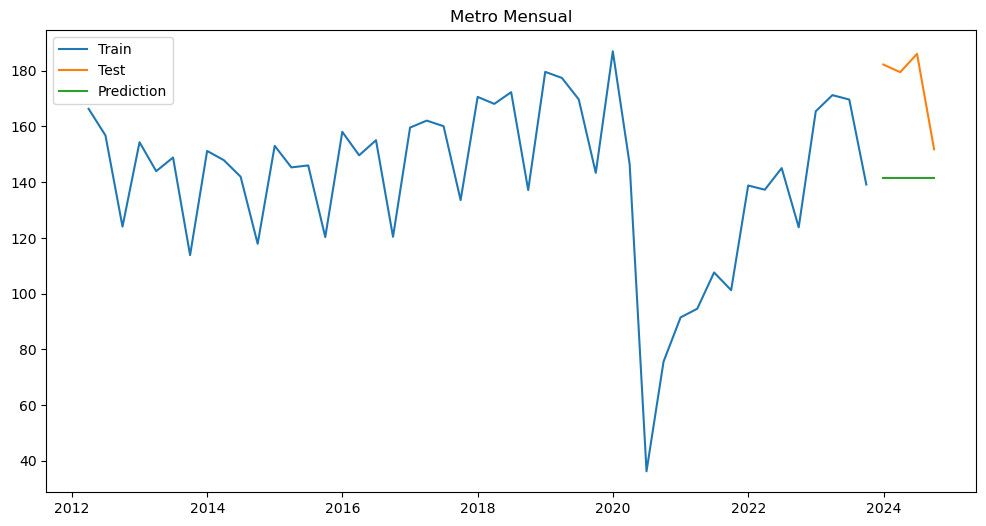

Combinado Mensual - MSE: 3139.86, RMSE: 56.03, MAPE: 16.67%


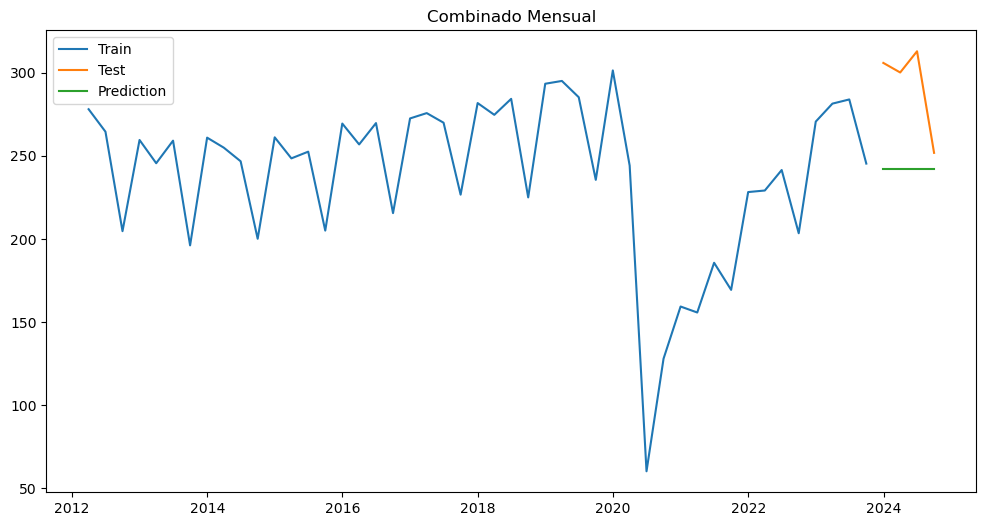

In [7]:
train_and_plot(df_autobus_trim, 'Autobús Mensual', test_size=4)
train_and_plot(df_metro_trim, 'Metro Mensual', test_size=4)
train_and_plot(df_combined_trim, 'Combinado Mensual', test_size=4)

A pesar de los esfuerzos realizados para ajustar el modelo XGBoostRegressor mediante técnicas avanzadas como la optimización bayesiana y la validación cruzada, los resultados obtenidos en la predicción de las series temporales de pasajeros de autobús y metro de Madrid no han sido satisfactorios. Aunque estas estrategias permitieron explorar de manera eficiente los hiperparámetros y mitigar el riesgo de sobreajuste, el modelo no logró capturar adecuadamente las dinámicas estacionales y de tendencia presentes en los datos. Las métricas de error como MSE, RMSE y MAPE reflejaron un desempeño inferior en comparación con otros modelos, como ETS y Theta, que se han mostrado más adecuados para este tipo de series temporales. Estos resultados sugieren que, aunque XGBoostRegressor es un modelo potente para problemas generales de regresión, sus capacidades no se ajustaron a las particularidades de las series temporales de transporte público, reafirmando la necesidad de utilizar enfoques específicos para este tipo de datos.

***

## Modelo LightGBM

El modelo LightGBMRegressor es un algoritmo de aprendizaje supervisado basado en la técnica de gradient boosting, diseñado para resolver problemas de regresión de manera eficiente y precisa. Este modelo utiliza un enfoque innovador basado en histogramas para construir árboles de decisión, lo que le permite ser más rápido y consumir menos memoria en comparación con otros algoritmos de boosting. LightGBMRegressor es especialmente eficaz en conjuntos de datos grandes y de alta dimensionalidad, y maneja de manera nativa características categóricas, valores faltantes y relaciones no lineales en los datos. Además, incluye técnicas avanzadas de regularización, como L1 y L2, para reducir el sobreajuste y mejorar la generalización. Su capacidad para ajustar patrones complejos lo hace una opción sólida en diversos dominios, aunque requiere un ajuste cuidadoso de sus hiperparámetros para alcanzar un rendimiento óptimo.

### Series mensuales LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 1
[LightGBM] [Info] Start training from score 32.409471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

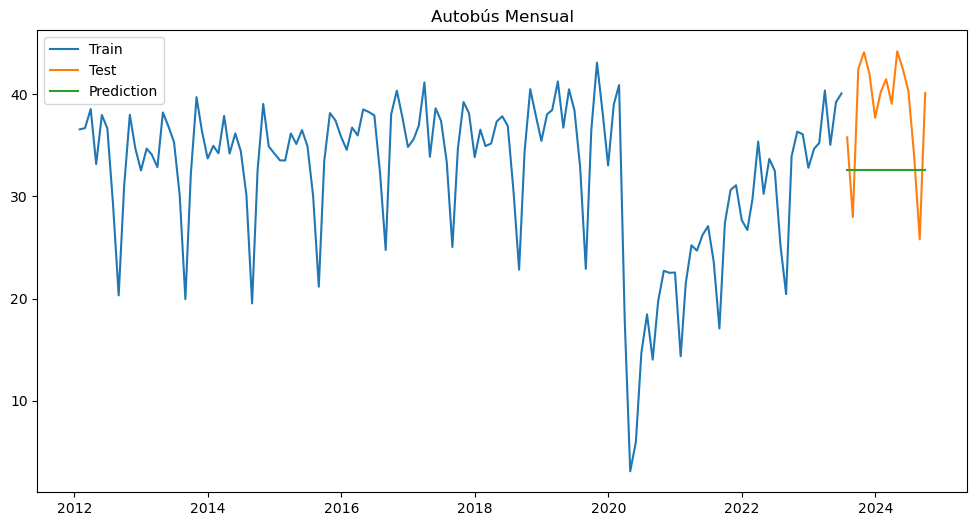

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 1
[LightGBM] [Info] Start training from score 47.395703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

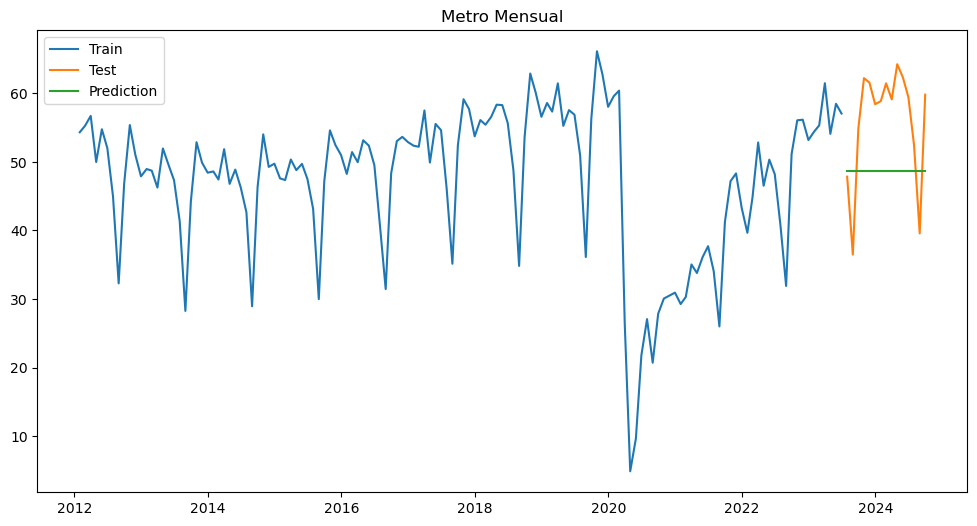

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 1
[LightGBM] [Info] Start training from score 79.805174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

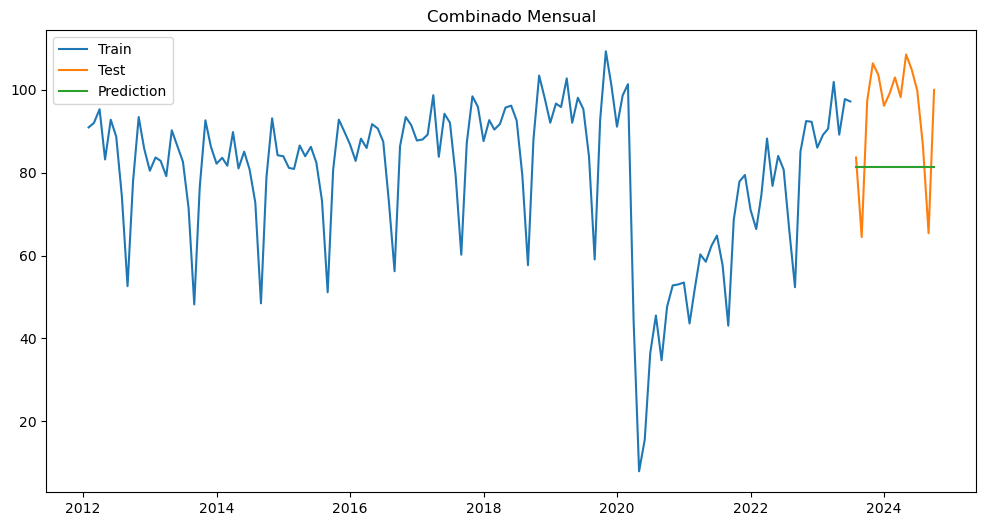

In [8]:
# Preparar los datos
def prepare_data(df):
    X = np.arange(len(df)).reshape(-1, 1)
    y = df.values
    return X, y

# Generar predicciones y graficar
def train_and_plot_lightgbm(df, title, test_size=15):
    X, y = prepare_data(df)
    
    # Ensure test_size does not exceed the length of the dataset
    test_size = min(test_size, len(df) - 1)
    
    # Dividir en train y test
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    
    # Definir el modelo base
    model = LGBMRegressor()
    
    # Definir el espacio de búsqueda
    search_spaces = {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(1, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0)
    }
    
    # Configurar la búsqueda bayesiana con validación cruzada
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=32,
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    # Entrenar el modelo
    opt.fit(X_train, y_train)
    
    # Mejor modelo
    best_model = opt.best_estimator_
    
    # Predicciones
    y_pred = best_model.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    print(f'{title} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}')
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[:-test_size], y_train, label='Train')
    plt.plot(df.index[-test_size:], y_test, label='Test')
    plt.plot(df.index[-test_size:], y_pred, label='Prediction')
    plt.title(title)
    plt.legend()
    plt.show()

# Aplicar a los tres dataframes mensuales
train_and_plot_lightgbm(df_autobus_month, 'Autobús Mensual')
train_and_plot_lightgbm(df_metro_month, 'Metro Mensual')
train_and_plot_lightgbm(df_combined_month, 'Combinado Mensual')

### Series trimestrales LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1
[LightGBM] [Info] Start training from score 97.419808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

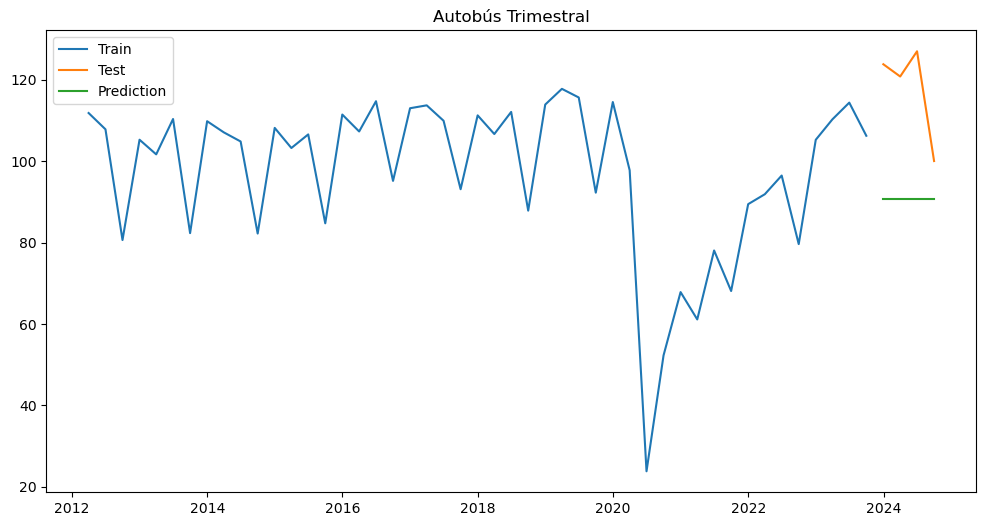

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1
[LightGBM] [Info] Start training from score 142.122937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

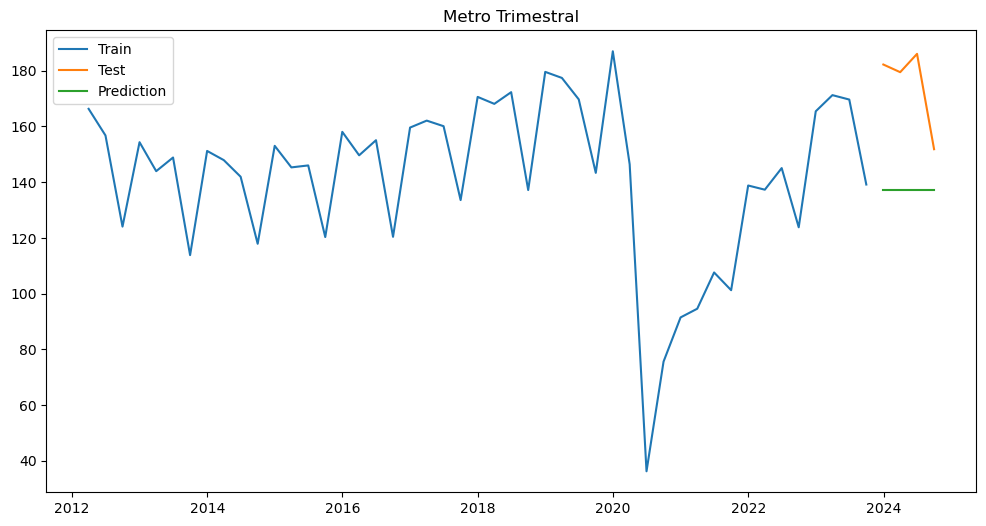

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1
[LightGBM] [Info] Start training from score 239.542745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

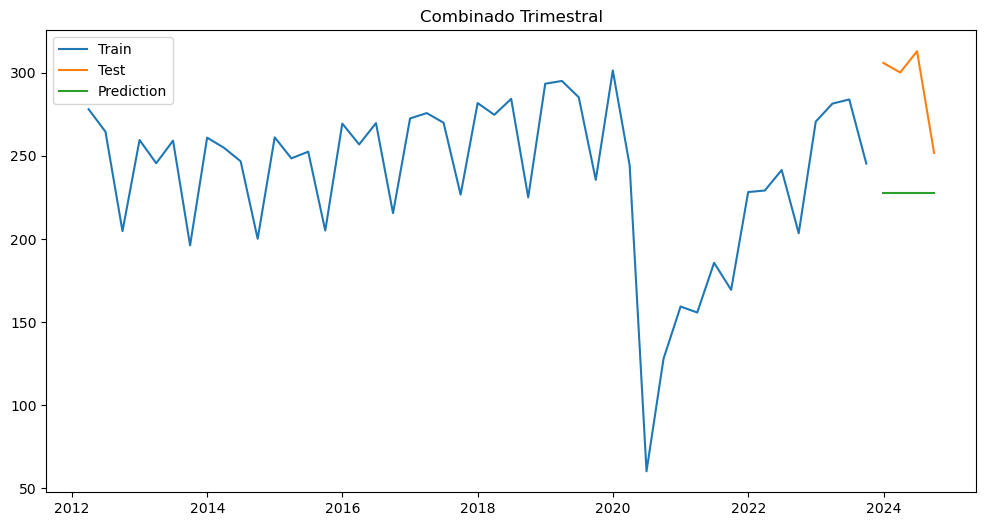

In [9]:
train_and_plot_lightgbm(df_autobus_trim, 'Autobús Trimestral', test_size=4)
train_and_plot_lightgbm(df_metro_trim, 'Metro Trimestral', test_size=4)
train_and_plot_lightgbm(df_combined_trim, 'Combinado Trimestral', test_size=4)

***

## Conclusiones XGBoost y LightGBM

Los modelos XGBoostRegressor y LightGBMRegressor, a pesar de ser algoritmos avanzados y altamente eficaces en muchos contextos, no han logrado generar predicciones precisas para las series temporales de pasajeros de autobús y metro de Madrid. A pesar de haber implementado técnicas sofisticadas como la optimización bayesiana y la validación cruzada para ajustar sus hiperparámetros, ambos modelos mostraron dificultades para capturar los patrones estacionales, tendencias y otras dinámicas inherentes a los datos temporales. Las métricas de error como MSE, RMSE y MAPE evidenciaron un desempeño inferior, y los resultados visuales no reflejaron una alineación adecuada con los valores reales, lo que pone en duda su efectividad en este contexto específico.

Estos resultados sugieren que, aunque XGBoostRegressor y LightGBMRegressor son modelos potentes para problemas generales de regresión, su enfoque basado en árboles y boosting puede no ser el más adecuado para series temporales con características complejas como las analizadas. Los patrones estacionales y de tendencia, elementos cruciales en los datos de transporte público, parecen no ser capturados de manera efectiva por estos modelos. En comparación, los modelos específicos de series temporales como ETS y Theta continúan ofreciendo mejores resultados, tanto en términos de métricas de error como de interpretabilidad, reafirmando la importancia de utilizar enfoques especializados para predecir este tipo de datos.